In [1]:
from sklearn.datasets import make_blobs, make_moons
import torch
from torch import nn
import pandas as pd
import seaborn as sns
import seaborn
from torch.optim import SGD
import torch.functional as F
import numpy as np

RANDOM_STATE = 45

np.random.seed(RANDOM_STATE)

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


def plot_decision_boundry(net, X, line='g--'):
    W = net.fc.weight[0].detach().cpu().numpy()
    b = net.fc.bias.detach().cpu().numpy()
    f = lambda x: (-W[0]/W[1]) * x +  (-b/W[1])
    dziedz = np.arange(-1, 1, 0.01)
    plt.plot(dziedz, f(dziedz), line) 
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))

# Prepare and Visualize data

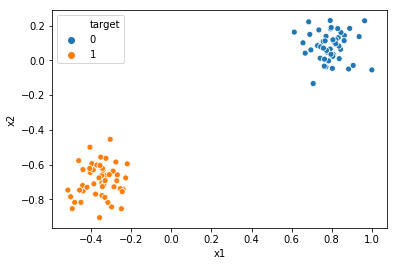

In [2]:
N_FEATURES = 2


X, Y = make_blobs(centers=2, center_box=(-10, 10), random_state=RANDOM_STATE, n_features=N_FEATURES)
# X, Y = make_moons()

X = X/np.abs(X).max()
# Y_one_hot = ohe.fit_transform(Y.reshape(-1, 1)).toarray()

data = pd.DataFrame(X, columns=['x1', 'x2'])
data['target'] = Y
seaborn.scatterplot(x='x1',y='x2', hue='target', data=data)

In [3]:
pd.DataFrame(X, columns=['A', 'B']).head()

,A,B
0,0.707380,-0.133517
1,-0.316867,-0.817494
2,0.792607,0.064959
3,-0.323771,-0.660196
4,-0.405178,-0.645079


In [4]:
pd.DataFrame(Y).head()

,0
0,0
1,1
2,0
3,1
4,1


# Define the perceptron


![alt text](https://i.stack.imgur.com/2MVdW.png "Title")


In [5]:
input_tensor = torch.randn((1,2))
print(input_tensor)
print(input_tensor[0][0])
linear_layer = nn.Linear(2,1)
output = linear_layer(input_tensor)
print(linear_layer.weight)
print(linear_layer.bias)
print(f'output: {output}')
print(f'manual computation: {np.dot(linear_layer.weight.detach().numpy(), input_tensor.detach().numpy().transpose()) + linear_layer.bias.detach().numpy()}')

tensor([[ 0.3008, -2.0550]])
tensor(0.3008)
Parameter containing:
tensor([[0.1188, 0.7047]], requires_grad=True)
Parameter containing:
tensor([0.1744], requires_grad=True)
output: tensor([[-1.2380]], grad_fn=<AddmmBackward>)
manual computation: [[-1.2379825]]


In [6]:

class Perceptron(nn.Module):
    def __init__(self, n_in, n_out):

        super(Perceptron, self).__init__()
        # self.fc = nn.Linear(n_in, n_out, bias=True)
        
        self.fc = nn.Sequential(OrderedDict([
            ('lin1', nn.Linear(n_in, 2, bias=True)),
            ('relu', nn.ReLU()),
            ('lin2', nn.Linear(2, n_out, bias=True)),
            ('sigmoid', nn.Sigmoid())
        ]))
        
        # self.fc1 = nn.Linear(n_in, 2, bias=True)
        # self.fc = nn.Linear(2, n_out, bias=True)
        
        # self.fc = nn.Sequential(nn.Linear(n_in, 2, bias=True), nn.Linear(2, n_out, bias=True))

        # Here we are defining the layers of the model
        # Linear layer = dense layer because every node has a connection to all other nodes
        # Expensive computationaly
    
    def forward(self, x):
        return self.fc(x)
    

def custom_weights(m):
    if type(m) == nn.Linear:
        # torch.nn.init.constant_(m.weight, 0)
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.05)
        # m.bias.data.fill_(0.05)

from collections import OrderedDict
        
perceptron = Perceptron(2, 1)
# We have 2 input nodes and 1 output node

# Linear layers get their weights initialized by default, but you can reinitialize them if needed.
perceptron.apply(custom_weights)



Perceptron(
  (fc): Sequential(
    (lin1): Linear(in_features=2, out_features=2, bias=True)
    (relu): ReLU()
    (lin2): Linear(in_features=2, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)

# Train Loop Using CrossEntropy



While using crossentropy loss our model needs to return (BS, n_classes) output tensor, the target has to be a coresponding dense label vector of shape (BS, 1)

In [7]:
# dir(perceptron)

In [8]:
# all the parameters from the net that are passed to the optimizer
net = Perceptron(2, 1)
list(net.parameters())

[Parameter containing:
 tensor([[-0.1413,  0.3857],
         [-0.4069,  0.4613]], requires_grad=True), Parameter containing:
 tensor([-0.6380, -0.2642], requires_grad=True), Parameter containing:
 tensor([[0.0622, 0.0650]], requires_grad=True), Parameter containing:
 tensor([-0.4256], requires_grad=True)]


input shape (BS, n_classes): torch.Size([1, 2])
target shape (BS, 1): torch.Size([1, 1])
output shape torch.Size([1, 1])


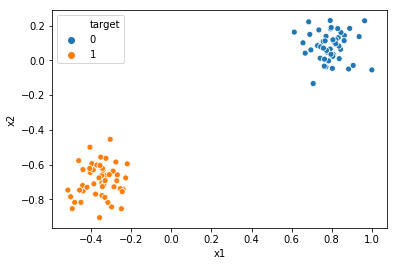

In [9]:
from tqdm import tqdm_notebook as tqdm

N_EPOCHS = 100

import pdb

# init the model, loss and optimizer
net = Perceptron(2, 1)
optimizer = SGD(net.parameters(), lr=0.005)
criterion = nn.BCELoss() # Binary Cross Entropy With Logits - see docs. Only with one class: 0 or1
net = net.to(DEVICE)

loss_history = []
for epoch in tqdm(range(N_EPOCHS)):
    for xsample,ysample in zip(X, Y):

        # zero the gradients: set the gradient again to zero at the beginning of the loop 
        # so we are fresh to make a new update
        optimizer.zero_grad() 
        
        # batch preparation: because they are still numpy arrays
        
        # we need to unsqueeze to add the batch dimension, this needs to be added as a rule for the network to work
        x = torch.Tensor(xsample).unsqueeze(0) # tensor([[0.8745, 0.5205]]) torch.Size([1, 2])
        y = torch.Tensor([ysample]).unsqueeze(0) # tensor([[1.]]) torch.Size([1, 1])
        
        # move the data to the device - this is optional
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        # forward pass, getting the prediction from the sample, this is normally very quick
        out = net(x)
        # in our case this is just a 1 number probability
        # suppose you have as input a 512x512 image and you have 10 objects you want to mask on it. Then your
        # output would have to be a [32,10,512,512] vector (32 for the batch size)
        
        # loss calculation
        loss = criterion(out, y) # calculating the Binary Cross Entropy 
        
        # calculating gradients
        loss.backward()
        
        # changing the weights by specified(in the optimizer init) learning rate
        optimizer.step()
        
        #append calculated loss to the history
        loss_history.append(loss.detach().cpu().numpy())
        #from neptune import Context
        #ctx = Context()
        #ctx.channel()
        
    # plot_decision_boundry(net, X)
    
# at the end plot final solution in red
# plot_decision_boundry(net, X, 'r-')
seaborn.scatterplot(x='x1',y='x2', hue='target', data=data)


print("input shape (BS, n_classes):", x.shape)
print("target shape (BS, 1):", y.shape)
print("output shape", out.shape)

Text(0, 0.5, 'loss (CE)')

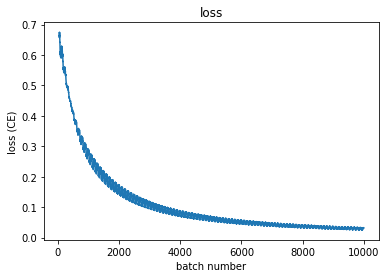

In [10]:
history = pd.DataFrame(loss_history, columns=['loss'])
history.loss.rolling(50).mean().plot()
plt.title("loss")
plt.xlabel("batch number")
plt.ylabel("loss (CE)")

#### Exercises
- Play with the training loop, enjoy the fact that you can inspect all the values dynamically. Consider using pdb.set_trace() for instance  
*done*
- Can you edit the Perceptron class to create a Multi Layer Perceptron? (ie having more then 0 hidden layers)  
*Yes, but be aware of the name conventions for visualisation! last layer needs to be fc*
- Initialize the the initial weights to 0. What do you think will happen? Can we still train the perceptron?  
*Yes, looks like you can. Also works with bias 0. 0 is as good of a guess as any other guess*
- What kind of gradient descent are we using here? Stochastic? Batch? or Vanilla?  
*Stochastic*
- What does detach do and why do we have to call it? (use google)  
*In a torch Tensor normally the history is saved to be able to calculate the gradient. By detaching you remove the history and convert it to a normal vector that then can be converted to e.g. a numpy array*
- Try adding a RELU activation after Linear unit - Will it train or not why?    
*It does train, but it can get stuck in 0.*
- Try to implement a progress-bar (it might come in handy in our future exercises to)


In [11]:
from IPython.display import HTML
HTML('<iframe src=https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.19214&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false width=1000 height=600></iframe>')

/Users/falkvandermeirsch/Documents/DSR/env/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


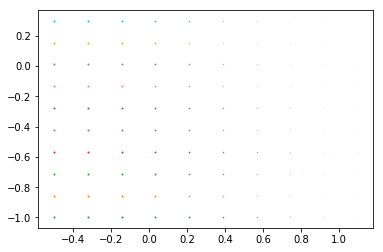

In [12]:
import matplotlib.pyplot as plt


for xcoord in np.linspace(-0.5,1.1,10):
    for ycoord in np.linspace(-1, 0.3, 10):
        plt.scatter(xcoord, ycoord, net(torch.Tensor([xcoord, ycoord])).detach())
        
plt.show()

In [16]:
xcoord = np.linspace(-0.5,1.1,10)
ycoord = np.linspace(-1, 0.3, 10)
X, Y = np.meshgrid(xcoord, ycoord)
Z = net(torch.Tensor([X, Y])).unsqueeze(0).detach()

plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()



RuntimeError: size mismatch, m1: [20 x 10], m2: [2 x 2] at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/wheel_3.7/pytorch/aten/src/TH/generic/THTensorMath.cpp:940